orginal repo : https://github.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy

In [1]:
import pandas as pd

telemetry = pd.read_csv('./data/PdM_telemetry.csv')
errors = pd.read_csv('./data/PdM_errors.csv')
maint = pd.read_csv('./data/PdM_maint.csv')
failures = pd.read_csv('./data/PdM_failures.csv')
machines = pd.read_csv('./data/PdM_machines.csv')

Data preprocessing

In [2]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')

maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')

machines['model'] = machines['model'].astype('category')

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

feature engineering

In [3]:
# Calculate mean values for telemetry features
# pivot_table을 이용 row 시간, columns machin_id 로 구성, 그 후 3시간별 평균으로 설정, 다시 원상복구
# 즉 3시간 기계별 3시간 평균 데이터 생성
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
# 추가적인 정보를 넣기 위해 3시간 분산 데이터 추가
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

In [4]:
# 위와 동일한 과정을 24단위 평균을 생성
# 이를 3시간 단위로 짜름(즉 3시간 마다 24시간 평균을 생성)
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                            index='datetime',
                            columns='machineID',
                            values=col).rolling(window=24).mean().resample('3H',
                                                                    closed='left',
                                                                    label='right').first().unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

# repeat for standard deviation
# 전체 데이터를 24단위 분산을 생성 
# 이를 3시간 단위로 짜름(즉 3시간 마다 24시간 분산을 생성)
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                                index='datetime',
                                columns='machineID',
                                values=col).rolling(window=24).std().resample('3H',
                                                                            closed='left',
                                                                            label='right').first().unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]
telemetry_sd_24h.reset_index(inplace=True)

In [5]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()

In [6]:
# create a column for each error type
# error 별 column 생성
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
# 같은 시간으로 통합
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
# telemetry 에 통합
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)

In [7]:
# 3시간 마다 24시간 에러 수 표시
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                                index='datetime',
                                columns='machineID',
                                values=col).rolling(window=24).sum().resample('3H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()

In [8]:
import numpy as np

# create a column for each error type
# 각 부품별로 생성후 column 명 설정
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
# 기계와 시간별로 교체 부품 정리
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
# telemetry 데이터에 데이터 결합
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None # 0.0인 위치를 모두 None 으로 변경
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    # -comp_rep[comp].isnull() comp_req 의 comp columns 에서 None 이 아닌 부분을 선택(즉 해당 부품의 교체가 발생된 날짜 선택)
    # 해당 부분의 내용을 시간으로 변경
    
    # forward-fill the most-recent date of component change
    # 나머지 빈 부분을 모두 해당 시간으로 교체 (즉 부품 교체일로 변경 날짜)
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
# 2014년 이상의 데이터만 선택
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent component change with days since most recent component change
# 각 comp 내용을 부품 교체일 부터 얼마나 지났는지로 변경
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')
    

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [9]:
# 통합 과정
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

In [10]:
# failure 결합
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
# fillna 가 str일 경우 작동하지 않는 문제 발견 하여 comp 의 마지막 단어를 추출하여 fillna 진행후 comp를 다시 붙이는 방식으로 해결
# labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features.failure = 'comp' + labeled_features.failure.str[-1].fillna(method='bfill', limit=7) # 앞선 7칸을 failure 로 설정
labeled_features.failure = labeled_features.failure.fillna('none') # 나머지를 none 으로 설정

Train

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
    test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'failure'], 1))
    # train and predict using the model, storing results for later
    my_model = GradientBoostingClassifier(random_state=42)
    my_model.fit(train_X, train_y)
    test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
    test_result['predicted_failure'] = my_model.predict(test_X)
    test_results.append(test_result)
    models.append(my_model)

Evaluation

Text(0, 0.5, 'Importance')

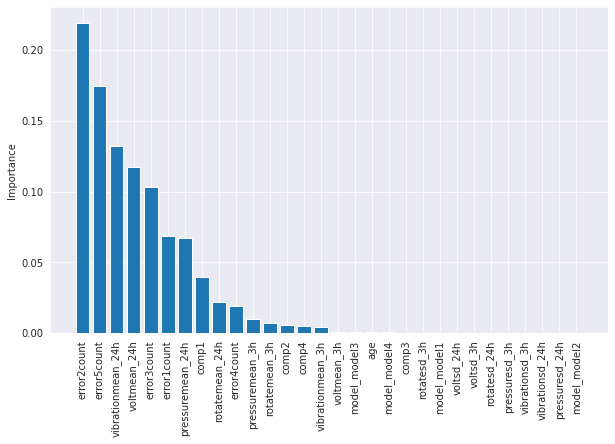

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

Text(0, 0.5, 'Count')

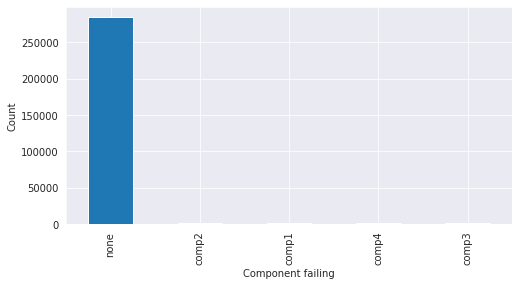

In [14]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
labeled_features['failure'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')

In [15]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [16]:
evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i+1))
    evaluation_result = Evaluate(actual = test_result['failure'],
                                 predicted = test_result['predicted_failure'],
                                 labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4'])
    evaluation_results.append(evaluation_result)
evaluation_results[0]  # show full results for first split only


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[119594     21      0      4      3]
 [    20    519      3      0      0]
 [     0      0    849      2     10]
 [    16      3      0    368      1]
 [     4      3      0      0    500]]

Split 2:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[91845  3285   143     1    12]
 [   37   379     2     0     4]
 [   17     0   663     0    20]
 [  290     5     2     7     2]
 [    6     2     4     0   388]]

Split 3:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[71634    31    31    14    28]
 [   23   293     2     1     1]
 [    2     1   545     0     0]
 [   28     1     1   194     0]
 [   12     1     5     0   262]]


,none,comp1,comp2,comp3,comp4
accuracy,0.999262,0.999262,0.999262,0.999262,0.999262
precision,0.999666,0.950549,0.996479,0.983957,0.972763
recall,0.999766,0.957565,0.986063,0.948454,0.986193
F1,0.999716,0.954044,0.991243,0.965879,0.979432
macro precision,0.980683,0.980683,0.980683,0.980683,0.980683
macro recall,0.975608,0.975608,0.975608,0.975608,0.975608
macro F1,0.978063,0.978063,0.978063,0.978063,0.978063
average accuracy,0.999705,0.999705,0.999705,0.999705,0.999705
micro-averaged precision/recall/F1,0.999262,0.999262,0.999262,0.999262,0.999262
majority class accuracy,0.981152,0.000000,0.000000,0.000000,0.000000
